In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax

In [14]:
no = ['/kaggle/input/brain-mri-images-for-brain-tumor-detection/no']
yes = ['/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes']
file_p = []
labels = []
dict_lists = [no, yes]
class_labels = ['no', 'yes']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [15]:
df.head()

,filepaths,labels
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no


In [16]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(160, 2)
(64, 2)
(29, 2)


In [17]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [18]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 160 validated image filenames belonging to 2 classes.
Found 64 validated image filenames belonging to 2 classes.
Found 29 validated image filenames belonging to 2 classes.


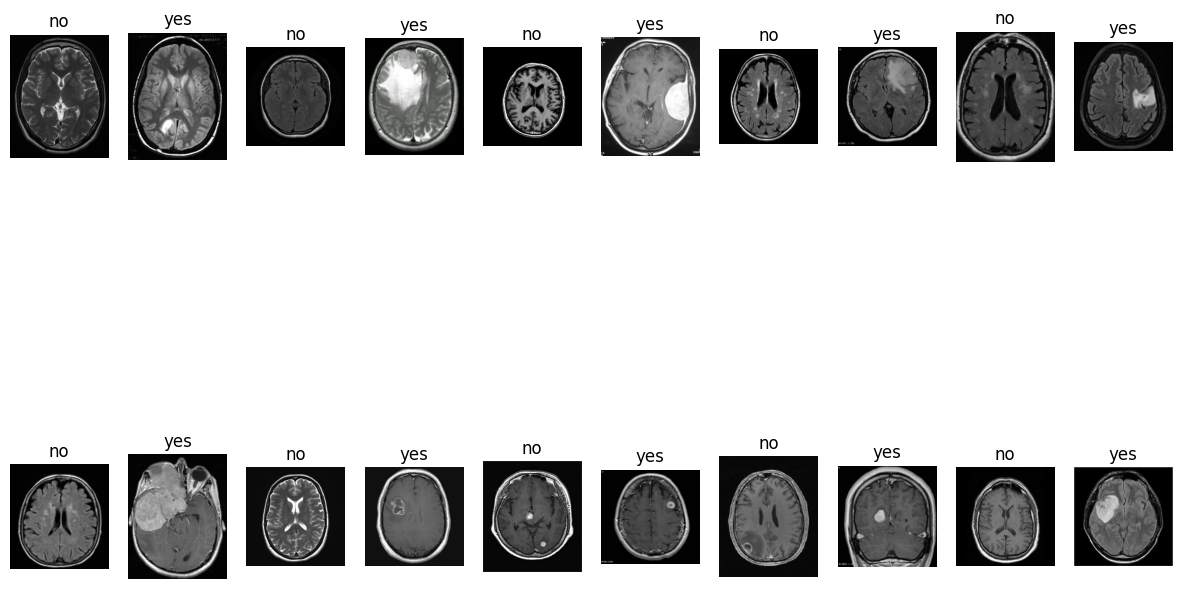

In [19]:
import matplotlib.pyplot as plt

# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()


In [27]:
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception

learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=150, validation_data=val)


Epoch 1/100


W0000 00:00:1713114991.859066      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 60s 10s/step - accuracy: 0.5229 - loss: 1.3939 - val_accuracy: 0.3793 - val_loss: 4.5989
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - accuracy: 0.9234 - loss: 0.3830 - val_accuracy: 0.3793 - val_loss: 6.2469
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/step - accuracy: 0.9758 - loss: 0.0781 - val_accuracy: 0.3793 - val_loss: 7.5789
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - accuracy: 0.9918 - loss: 0.0307 - val_accuracy: 0.3793 - val_loss: 8.4182
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 724ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.3793 - val_loss: 8.5016
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.3793 - val_loss: 8.4446
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 718ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.3793 - val_loss: 8.1915
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - accuracy: 0.9910 - loss: 0.0124 - val_accuracy: 0.3793 - val_loss: 7.70

In [28]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9062 - loss: 0.7449
Test Loss: 0.7449304461479187
Test Accuracy: 0.90625


W0000 00:00:1713115256.018537      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


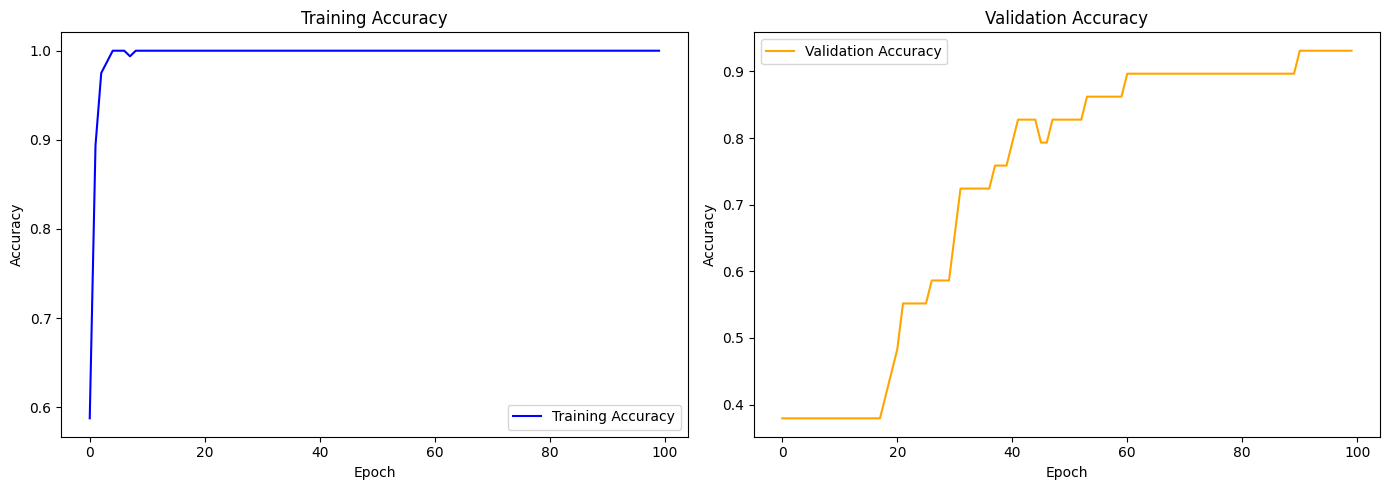

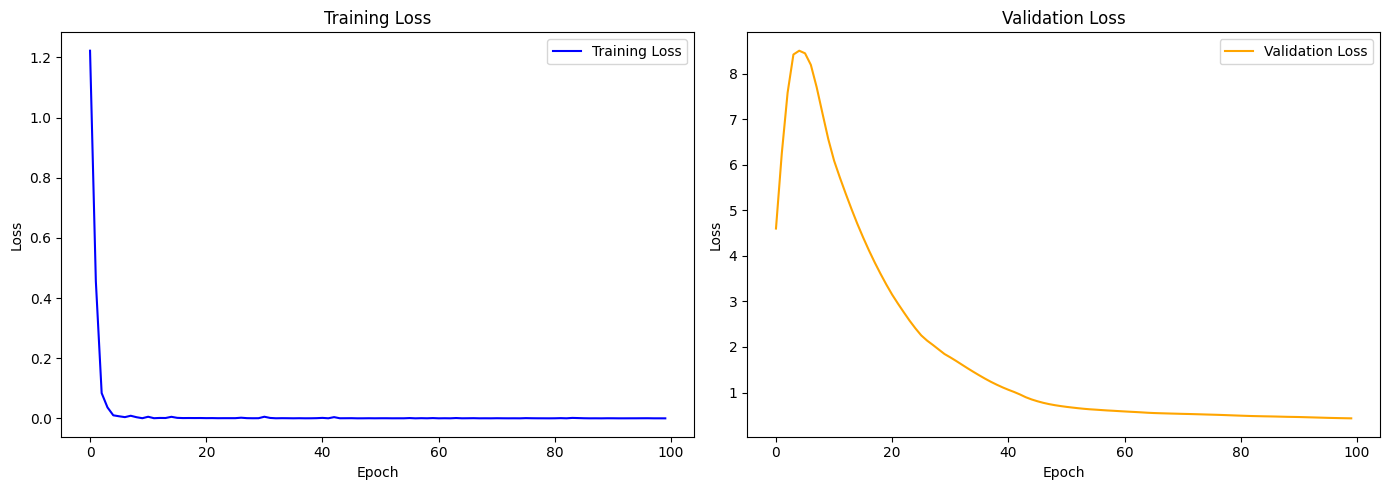

In [29]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


W0000 00:00:1713115271.702142      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


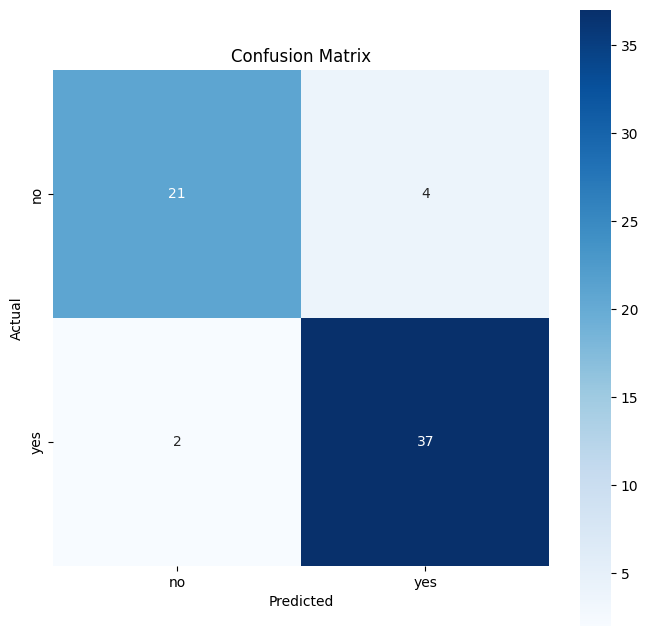

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
